# **Logistic Regression from Scratch**

## 1. Problem Setup

This notebook addresses a binary classification problem: given numerical features describing a tumor, the goal is to predict whether it is malignant or benign. We use the **Breast Cancer Wisconsin** dataset, which consists of numeric features derived from medical imaging and a binary target label.

**Crucially, we define the "Positive Class" (1) as Malignant and the "Negative Class" (0) as Benign.** This aligns with standard medical diagnostic terminology, where a "positive" test indicates the presence of the disease (cancer).

**Logistic regression** is used here as an interpretable baseline. It estimates the probability ($p$) that an input belongs to the positive class (Malignancy). This formulation allows us to directly optimize for cancer detection and interpret feature weights as risk factors.

The notebook covers:
1.  **Exploratory Data Analysis (EDA):** Understanding feature distributions and class imbalance.
2.  **Implementation from Scratch:** Building the optimization loop in PyTorch.
3.  **Evaluation:** Measuring success using Precision (confidence) and Recall (sensitivity to cancer).
4.  **Interpretability:** Mapping model weights back to physical tumor characteristics.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
%matplotlib inline

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)
df = data.frame


# Invert the target labels so 1 = Malignant, 0 = Benign
df["target"] = 1 - df["target"]

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## 2. Exploratory Data Analysis (EDA)

### Class Distribution

We begin by examining the distribution of the target variable to assess class balance.

The dataset contains 357 benign cases (≈63%) and 212 malignant cases (≈37%). This represents a moderate class imbalance, with malignant tumors forming the minority class.

While the imbalance is not severe, accuracy alone can be misleading in
imbalanced settings. We therefore evaluate performance using precision,
recall, and ROC curves, which provide a more complete picture of
classification performance across different decision thresholds.

**When to Use Class Weights:**

Class weights are most valuable when:
- Minority class <10-15% (severe imbalance)
- Cost of errors differs dramatically between classes
- Model shows systematic bias toward majority class

In our case, the 37/63 split suggests standard training is sufficient.
For more severe imbalance (<10% minority class), techniques like class
weighting, SMOTE, or focal loss would be warranted. Here, we prioritize
coefficient interpretability for clinical stakeholders.

**Decision**: We use standard (unweighted) logistic regression to maintain
coefficient interpretability for clinical stakeholders.

In [ ]:
df["target"].value_counts()

,count
target,
0,357
1,212


In [ ]:
df["target"].value_counts(normalize=True)

,proportion
target,
0,0.627417
1,0.372583


Next, we examine feature distributions and relationships to understand scale differences and potential correlations among predictors.

### Feature Distributions and Scale

We examine the marginal distributions of the input features to assess differences in scale, shape, and spread across predictors.

The histograms reveal substantial variation in both scale and distributional form. Some features (e.g., area- and perimeter-related measurements) span much larger numeric ranges than others, while several variables exhibit right-skewed distributions.

These scale differences do not affect the expressiveness of logistic regression, but they strongly influence gradient-based optimization. Without feature scaling, parameters associated with large-magnitude features can dominate gradient updates, slowing convergence or leading to unstable training. This motivates explicit feature standardization prior to model fitting.

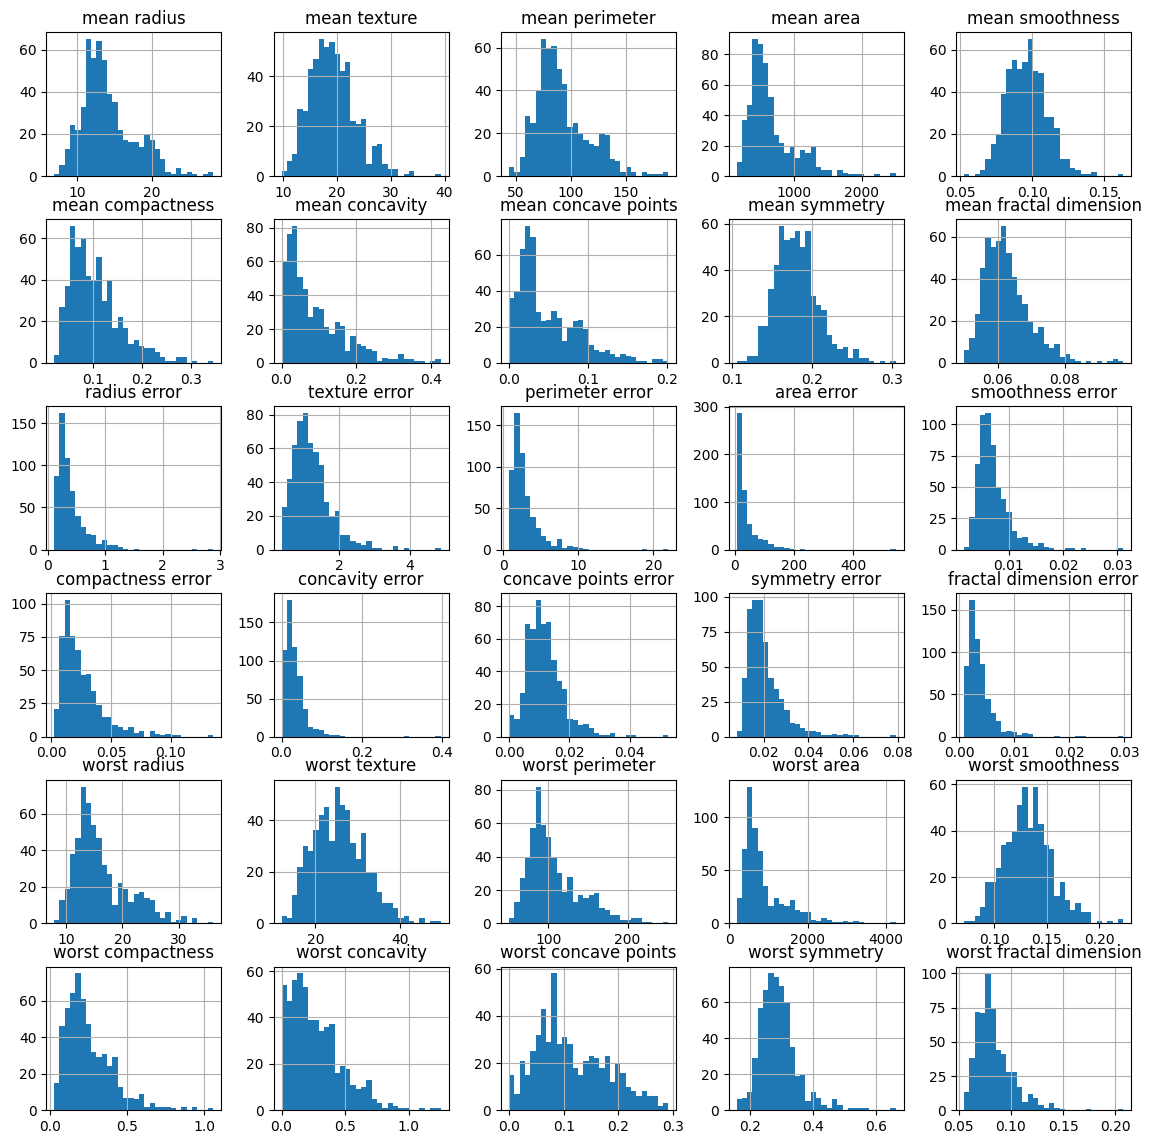

In [ ]:
df.drop(columns="target").hist(bins=30, figsize=(14, 14))
plt.show()

### Feature Distributions by Class

In [ ]:
features = [
    "mean radius",
    "mean perimeter",
    "mean area",
    "mean concavity"
]

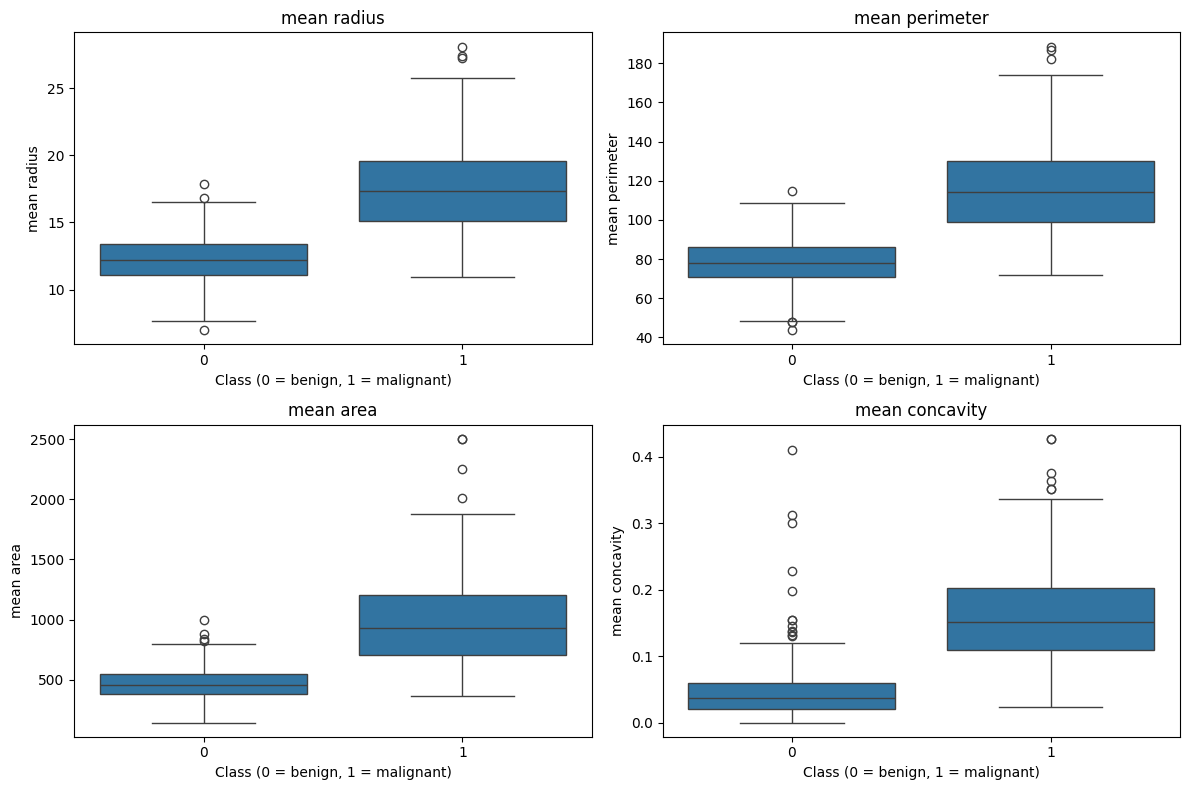

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, feature in zip(axes, features):
    sns.boxplot(x="target", y=feature, data=df, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("Class (0 = benign, 1 = malignant)")

plt.tight_layout()
plt.show()

The box plots compare the distributions of selected features across the two classes, where **0 corresponds to benign tumors and 1 corresponds to malignant tumors**.

For all features shown, malignant tumors tend to exhibit larger values and greater variability than benign tumors. In particular, radius, perimeter, area, and concavity-related measurements show clear separation between classes, with relatively limited overlap in their interquartile ranges.

These patterns suggest that geometric characteristics of the tumor are strongly associated with malignancy and are likely to be informative predictors for a linear classifier such as logistic regression.

### EDA Summary

The data exhibits moderate class imbalance, wide variation in feature scales, and partial class separation across multiple features, motivating feature scaling and a multivariate probabilistic classification approach.

## 3. Data Quality Checks

Before modeling, we perform basic data quality checks to verify that the dataset is suitable for supervised classification. At this stage, the focus is on identifying structural issues—such as missing values, duplicate records, or invalid labels—rather than feature engineering or model refinement.

In [ ]:
# Missing values
df.isna().sum()

,0
mean radius,0
mean texture,0
mean perimeter,0
mean area,0
mean smoothness,0
mean compactness,0
mean concavity,0
mean concave points,0
mean symmetry,0
mean fractal dimension,0


In [ ]:
# Duplicate Observations
df.duplicated().sum()

np.int64(0)

In [ ]:
# Target Variable Classes
df["target"].unique()

array([1, 0])

In [ ]:
# Summary Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


### Data Quality Summary

The dataset contains no missing values or duplicate observations, and the target variable is correctly encoded with two valid classes. Feature ranges and summary statistics are consistent with the dataset documentation and prior exploratory analysis.

No additional data cleaning is required at this stage. Subsequent preprocessing is limited to feature scaling to support stable gradient-based optimization.

## 4. Transition to PyTorch and Feature Scaling

We now transition from pandas DataFrames to PyTorch tensors in preparation for implementing the logistic regression model from scratch.

Logistic regression trained with gradient-based optimization is sensitive to feature scale. When input features differ substantially in magnitude, parameters associated with larger-scale features can dominate gradient updates, leading to slow or unstable convergence. To mitigate this effect, feature scaling is applied prior to training.

## 4.1 Separate Features and Target

We first separate the input features from the target variable and convert them to PyTorch tensors.

In [ ]:
import torch

# Separate features and target
X_np = df.drop(columns="target").values
y_np = df["target"].values

# Convert to PyTorch tensors
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).view(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: torch.Size([569, 30])
y shape: torch.Size([569, 1])


### Note on Tensor Shapes

Let \(N\) denote the number of samples and \(D\) the number of input features.

- **Feature matrix:** *N x D*

- **Weight vector:** *D x 1*

- **Linear output:** *N x 1*

- **Predicted probabilities:** *N x 1*

The original target array has shape (N,), representing one label per sample. This is a **one-dimensional vector**.

Logistic regression produces predictions as a **column vector** of shape (N, 1), with one probability per sample.  
We therefore reshape the target labels from (N,) to (N, 1) so that targets and predictions have matching shapes.

This explicit reshaping:

- Converts the targets from **1D to 2D**
- Ensures correct element-wise loss computation
- Avoids relying on implicit broadcasting

Matching tensor shapes becomes especially important when moving to neural networks, where silent broadcasting errors can lead to incorrect results.

## 4.2 Shuffle and Train/Test Split

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)

n = X.shape[0]
perm = torch.randperm(n)

X = X[perm]
y = y[perm]

train_size = int(0.8 * n)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

The dataset is shuffled prior to splitting to prevent any artifacts introduced by the original ordering of observations. An 80/20 split is used, with the training set reserved for parameter estimation and the test set held out for evaluation.

## 4.3 Feature Scaling (Standardization)

In [ ]:
# Compute mean and std from training data
X_mean = X_train.mean(dim=0, keepdim=True)
X_std = X_train.std(dim=0, keepdim=True)

# Standardize features
X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

We standardize each feature by subtracting the training-set mean and dividing by the training-set standard deviation. Importantly, scaling parameters are computed using only the training data and then applied to both the training and test sets to avoid information leakage.

After scaling, features are approximately centered at zero with unit variance. This ensures that gradient updates are comparable across features, improving numerical stability and convergence behavior during optimization.

With the data represented as scaled PyTorch tensors, we are now ready to implement logistic regression from scratch.

## 5. Logistic Regression From Scratch

We implement logistic regression directly using PyTorch tensors, without relying on high-level abstractions such as `nn.Linear` or built-in loss functions. This explicit implementation makes the interaction between probabilities, loss functions, and gradient-based optimization transparent.

Logistic regression models the probability of the positive class as a sigmoid transformation of a linear function of the input features:

$$
p(y = 1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b)
$$

where $\sigma$ denotes the sigmoid function, which maps real-valued inputs to probabilities in the range $[0, 1]$.



## 5.1 Sigmoid Function

The sigmoid function maps any real-valued input to the interval \(0, 1)\, making it well suited for modeling probabilities in binary classification problems.

Large positive values of the linear score produce probabilities close to 1, while large negative values produce probabilities close to 0. When the score is zero, the sigmoid outputs 0.5, corresponding to maximum uncertainty between the two classes.

In logistic regression, the input to the sigmoid function is a linear combination of the features:

$$
z = w^\top x + b
$$

The sigmoid function then converts this linear score into a probability:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

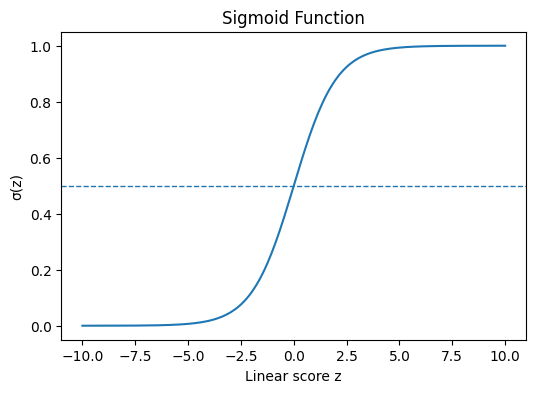

In [ ]:
#@title Sigmoid Function (Visualization only)
#@markdown This plot illustrates the shape of the sigmoid function and is not used in model training.

z = torch.linspace(-10, 10, 200)
plt.figure(figsize=(6, 4))
plt.plot(z, torch.sigmoid(z))
plt.axhline(0.5, linestyle="--", linewidth=1)
plt.xlabel("Linear score z")
plt.ylabel("σ(z)")
plt.title("Sigmoid Function")
plt.show()

In [ ]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

## 5.2 Forward Pass (Probability Prediction)

The forward pass computes predicted class probabilities by applying the sigmoid function to the linear model output.

In [ ]:
def predict_proba(X):
    return sigmoid(X @ w + b)

## 5.3 Binary Cross-Entropy Loss
To train the model, we minimize the binary cross-entropy (log loss), which penalizes confident incorrect predictions more heavily than squared error.

$$
L(w,b) = -\frac{1}{N}\sum_{i=1}^{N}\left(y_i\log(p_i) + (1-y_i)\log(1-p_i)\right)
$$

where $p_i = p(y = 1 \mid x_i)$

Binary cross-entropy measures the alignment between predicted probabilities and true class labels. The loss is small when the model assigns high probability to the correct class and increases rapidly when the model is confident but wrong. This property encourages not only correct classification, but also well-calibrated probability estimates.

From a probabilistic perspective, minimizing binary cross-entropy is equivalent to maximizing the likelihood of the observed labels under a Bernoulli model.

In [ ]:
def binary_cross_entropy(y_pred, y_true):
    eps = 1e-7  # avoid log(0)
    return -(
        y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps)
    ).mean()

The eps (epsilon) value (e.g., 1e-7) is added to y_pred and 1 - y_pred before taking the logarithm. This is a common practice to prevent log(0) errors, which would result in NaN (Not a Number) values and crash the training process. When y_pred is exactly 0 or 1, log(0) would occur. Adding a tiny eps ensures that the argument to log is always a small positive number, maintaining numerical stability without significantly affecting the loss calculation.

## 5.4 Training Loop (Gradient Descent)

Model parameters are updated using gradient descent. At each iteration, the gradient of the loss function with respect to the model parameters is computed and used to update the weights in the direction that reduces the loss:

$$
w \leftarrow w - \eta \frac{\partial L}{\partial w}
\qquad
b \leftarrow b - \eta \frac{\partial L}{\partial b}
$$

where $\eta$ is the learning rate.


Calling `loss.backward()` computes the gradients of the loss with respect to each parameter:

- `w.grad` stores:
$$
\frac{\partial L}{\partial w}
$$

- `b.grad` stores:
$$
\frac{\partial L}{\partial b}
$$


PyTorch accumulates gradients by default across backward passes. If gradients are not reset, each new gradient is added to the previous one, causing parameter updates to use incorrect gradient values.

To ensure that each training step updates the model using only the gradient from the current pass, we explicitly reset the gradients **after each parameter update, before the next training iteration**:

```python
w.grad.zero_()
b.grad.zero_()
```

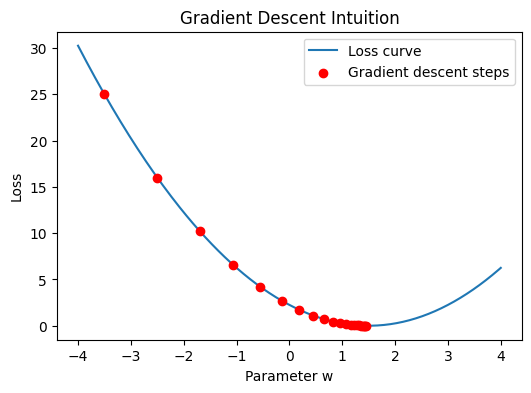

In [ ]:
#@title Gradient Descent Intuition (Visualization only)
#@markdown This visualization is conceptual and not part of the logistic regression model.

# Visualizing gradient descent on a simple quadratic loss
w_vals = torch.linspace(-4, 4, 200)
loss_vals = (w_vals - 1.5) ** 2  # simple convex loss

# Simulate gradient descent steps
w = torch.tensor(-3.5)
lr = 0.1
trajectory = [w.item()]

for _ in range(20):
    grad = 2 * (w - 1.5)
    w = w - lr * grad
    trajectory.append(w.item())

plt.figure(figsize=(6, 4))
plt.plot(w_vals, loss_vals, label="Loss curve")
plt.scatter(trajectory, [(x - 1.5)**2 for x in trajectory],
            color="red", zorder=3, label="Gradient descent steps")
plt.xlabel("Parameter w")
plt.ylabel("Loss")
plt.title("Gradient Descent Intuition")
plt.legend()
plt.show()

Above visualization illustrates the general intuition behind gradient descent using a simple one-dimensional loss function.  
In logistic regression, the loss is defined over many parameters and cannot be visualized directly. However, the same update principle applies independently to each parameter during training.

### Initialize Model Parameters

In [ ]:
# Number of features (assuming 'd' is defined, if not, it should be d = X_train_scaled.shape[1])
d = X_train_scaled.shape[1]

# Initialize weights and bias (ensure these are correctly initialized as global variables)
w = torch.zeros((d, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


### Shape Summary Table

| Element        | Meaning              | Shape  |
|-----------------|----------------------|--------|
| `X`             | Input features       | `(N, D)` |
| `w`             | Weights              | `(D, 1)` |
| `b`             | Bias                 | `(1,)` |
| `X @ w`         | Linear scores        | `(N, 1)` |
| `X @ w + b`     | Affine scores        | `(N, 1)` |
| `sigmoid(...)`  | Probabilities        | `(N, 1)` |

In [ ]:
learning_rate = 1e-2
num_epochs = 200

losses = []
train_acc_history = []
test_acc_history  = []

for epoch in range(num_epochs):
    # Forward pass (training data)
    y_pred = predict_proba(X_train_scaled)
    loss = binary_cross_entropy(y_pred, y_train)

    # Backward pass
    loss.backward()

    # Parameter update
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Reset gradients
    w.grad.zero_()
    b.grad.zero_()

    # Record loss
    losses.append(loss.item())

    # ---- Accuracy tracking (no gradients) ----
    with torch.no_grad():
        # Train accuracy
        train_probs = predict_proba(X_train_scaled)
        train_pred  = (train_probs >= 0.5).float()
        train_acc   = (train_pred == y_train).float().mean()

        # Test accuracy
        test_probs = predict_proba(X_test_scaled)
        test_pred  = (test_probs >= 0.5).float()
        test_acc   = (test_pred == y_test).float().mean()

    train_acc_history.append(train_acc.item())
    test_acc_history.append(test_acc.item())

    if epoch % 20 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {loss.item():.4f} | "
            f"Train Acc: {train_acc.item():.4f} | "
            f"Test Acc: {test_acc.item():.4f}"
        )

Epoch 000 | Loss: 0.6931 | Train Acc: 0.9385 | Test Acc: 0.9035
Epoch 020 | Loss: 0.4570 | Train Acc: 0.9407 | Test Acc: 0.9211
Epoch 040 | Loss: 0.3605 | Train Acc: 0.9473 | Test Acc: 0.9211
Epoch 060 | Loss: 0.3069 | Train Acc: 0.9538 | Test Acc: 0.9211
Epoch 080 | Loss: 0.2721 | Train Acc: 0.9604 | Test Acc: 0.9211
Epoch 100 | Loss: 0.2472 | Train Acc: 0.9648 | Test Acc: 0.9211
Epoch 120 | Loss: 0.2283 | Train Acc: 0.9648 | Test Acc: 0.9211
Epoch 140 | Loss: 0.2133 | Train Acc: 0.9670 | Test Acc: 0.9211
Epoch 160 | Loss: 0.2012 | Train Acc: 0.9692 | Test Acc: 0.9211
Epoch 180 | Loss: 0.1910 | Train Acc: 0.9692 | Test Acc: 0.9298


**Note:**

The parameter update is wrapped in `torch.no_grad()` to prevent PyTorch from tracking these operations in the computation graph.

Parameter updates are part of the optimization procedure, not the model itself. If gradient tracking were enabled during updates, PyTorch would attempt to differentiate through the optimizer, causing unnecessary graph growth and incorrect gradient behavior.

Using `torch.no_grad()` ensures that parameter updates are applied as simple numerical assignments without affecting the gradient computation for subsequent training steps.

## 5.5 From Probabilities to Class Label

Logistic regression outputs probabilities rather than discrete class labels. To obtain predicted labels, probabilities are converted to class assignments using a decision threshold.

$$
\hat{y} =
\begin{cases}
1 & \text{if } p(y=1 \mid \mathbf{x}) \geq 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

The threshold of 0.5 is a common default and corresponds to predicting the class with higher estimated probability. This thresholding step is applied only after training and is used exclusively for prediction and evaluation.

## 5.6 Training Diagnostics

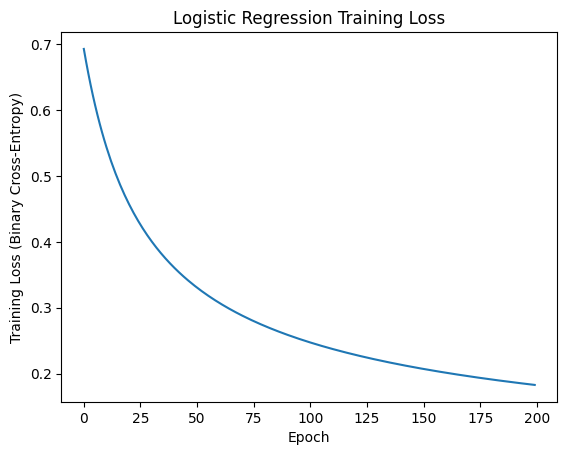

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (Binary Cross-Entropy)")
plt.title("Logistic Regression Training Loss")
plt.show()

The training loss decreases smoothly over successive epochs, indicating stable optimization and effective gradient-based learning. There are no signs of divergence or oscillation, suggesting that the learning rate is appropriately chosen.

The gradual flattening of the curve reflects diminishing returns from further training, as the model approaches a local optimum. This behavior is consistent with a well-conditioned logistic regression model trained on standardized features.

Model performance is evaluated next using held-out test data.

### 5.7 Model Diagnostics and Interpretation

We evaluate the trained logistic regression model on the held-out test set to assess its classification performance and probability estimates.

Using a decision threshold of 0.5, predicted probabilities are converted into class labels. The resulting test accuracy is high, indicating strong overall performance. However, accuracy alone does not fully characterize classification behavior, particularly in the presence of class imbalance.

In [ ]:
with torch.no_grad():
    logits = X_test_scaled @ w + b
    probs = torch.sigmoid(logits)
    y_pred = (probs >= 0.5).float()

In [ ]:
probs[:10], y_pred[:10]

(tensor([[0.1834],
         [0.2672],
         [0.0245],
         [0.0335],
         [0.9944],
         [0.9992],
         [0.9691],
         [0.3940],
         [0.0629],
         [0.1217]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.]]))

In [ ]:
torch.stack([y_test[:10], y_pred[:10]], dim=1)

tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[1.],
         [1.]],

        [[1.],
         [1.]],

        [[1.],
         [1.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]])

In [ ]:
accuracy = (y_pred == y_test).float().mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9298


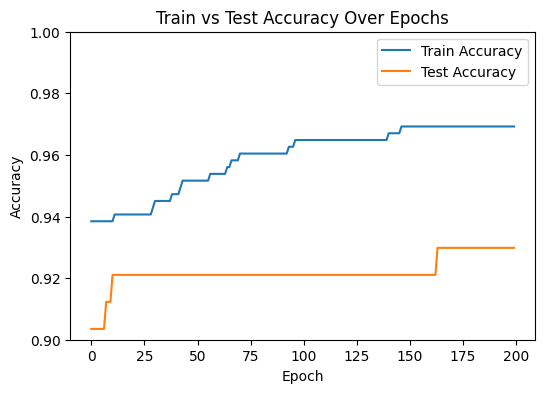

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.90, 1)   # 👈 important
plt.title("Train vs Test Accuracy Over Epochs")
plt.legend()
plt.show()

***Training vs. Test Accuracy Over Epochs***

The plot shows how accuracy evolves on both the training and test sets as the model parameters are updated during training. Training accuracy increases steadily and quickly plateaus, indicating that the model fits the training data well early on.

Test accuracy improves more gradually and exhibits a step-like pattern. This behavior is expected because accuracy is a discrete metric that changes only when enough predicted probabilities cross the classification threshold. Small improvements in predicted probabilities may not immediately translate into higher accuracy.

### Confusion Matrix and Classification Metrics

To better understand the types of errors made by the model, we examine the confusion matrix and derived metrics. In this formulation, the Positive Class (1) represents Malignant tumors, and the Negative Class (0) represents Benign tumors.

* True Positives (TP): Malignant tumors correctly classified as Malignant.

* True Negatives (TN): Benign tumors correctly classified as Benign. (Correct clearance).

* False Positives (FP): Benign tumors incorrectly classified as Malignant. (Type I Error: "False Alarm").

* False Negatives (FN): Malignant tumors incorrectly classified as Benign. (Type II Error: "Missed Diagnosis").

From the confusion matrix, we compute Precision and Recall for the positive class (Malignancy).

**Precision** measures trustworthiness: When the model predicts cancer, how often is it right?

**Recall (Sensitivity)** measures safety: Out of all actual cancer cases, how many did the model catch?

In [ ]:
# Calculate elements of the confusion matrix
# Note: target labels have been flipped so that 1 = Malignant

tp = ((y_pred == 1) & (y_test == 1)).sum().item() # Correctly identified Malignancy
tn = ((y_pred == 0) & (y_test == 0)).sum().item() # Correctly identified Benign
fp = ((y_pred == 1) & (y_test == 0)).sum().item() # False Alarm (Benign called Malignant)
fn = ((y_pred == 0) & (y_test == 1)).sum().item() # Missed Diagnosis (Malignant called Benign)

print(f"True Positives (Malignant): {tp}")
print(f"True Negatives (Benign):    {tn}")
print(f"False Positives (False Alarm): {fp}")
print(f"False Negatives (Missed Case): {fn}")

True Positives (Malignant): 43
True Negatives (Benign):    63
False Positives (False Alarm): 5
False Negatives (Missed Case): 3


In [ ]:
# The formulas remain exactly the same
precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)

# Update the print statements to reflect the new "Malignant" focus
print(f"Precision (Confidence in Cancer Prediction): {precision:.4f}")
print(f"Recall    (Sensitivity to Cancer Cases):     {recall:.4f}")

Precision (Confidence in Cancer Prediction): 0.8958
Recall    (Sensitivity to Cancer Cases):     0.9348


The model achieves high precision (0.8958) and recall (0.9348) for the malignant class. This indicates that when the model predicts malignancy, it is highly likely to be correct (high precision), and it successfully identifies a large proportion of all actual malignant cases (high recall), minimizing dangerous missed diagnoses (false negatives). This strong performance suggests effective separation between the two classes under the chosen threshold.

### ROC Curve and AUC

While accuracy, precision, and recall depend on a fixed decision threshold, the Receiver Operating Characteristic (ROC) curve evaluates model performance across all possible thresholds.

The ROC curve plots the true positive rate (recall) against the false positive rate as the classification threshold varies. The Area Under the Curve (AUC) summarizes this behavior into a single scalar between 0 and 1.

An AUC of 0.5 corresponds to random guessing, while an AUC of 1.0 indicates perfect class separation. The observed AUC is close to 1, indicating that the model assigns consistently higher probabilities to the correct class across a wide range of thresholds.

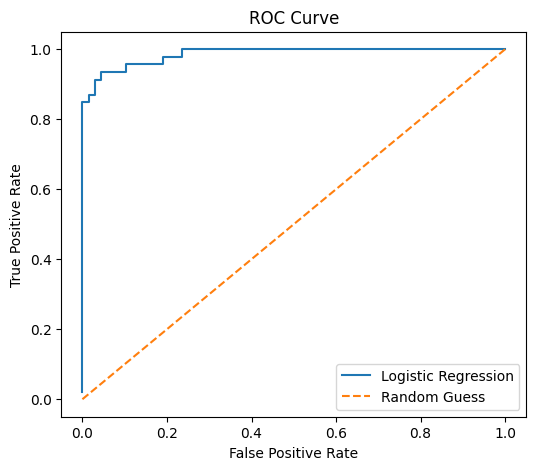

AUC: 0.9859


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to numpy
y_true = y_test.cpu().numpy()
y_scores = probs.cpu().numpy().ravel()

# Sort by descending probability
sorted_indices = np.argsort(-y_scores)
y_true_sorted = y_true[sorted_indices]

# Compute TPR and FPR
tp = 0
fp = 0
fn = np.sum(y_true_sorted)
tn = len(y_true_sorted) - fn

tpr = []
fpr = []

for y in y_true_sorted:
    if y == 1:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1
    tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0) # Handle potential division by zero
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0) # Handle potential division by zero

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Calculate AUC using the trapezoidal rule (numerical integration of the ROC curve)
auc = np.trapz(tpr, fpr)
print(f"AUC: {auc:.4f}")

Taken together, the evaluation metrics indicate that the logistic regression model achieves strong classification performance with well-calibrated probability estimates. Despite its linear decision boundary, the model effectively separates benign and malignant tumors in this dataset.

These results highlight both the strengths and limitations of logistic regression: strong performance and interpretability in settings with approximately linear class separation, but limited capacity to model more complex nonlinear patterns.

## 5.8 Feature Importance and Model Interpretability

One advantage of logistic regression is its interpretability. Each model coefficient represents the contribution of a feature to the log-odds of the **positive class (Malignant tumors)**.

* **Positive Coefficients (+):** Increasing this feature *increases* the probability of Malignancy (e.g., larger tumor area).
* **Negative Coefficients (-):** Increasing this feature *decreases* the probability of Malignancy (making it more likely Benign).

Features with larger absolute coefficients have a stronger overall influence on the model’s predictions.

In [ ]:
import pandas as pd
import numpy as np

# Define feature names (adjust column drop if needed)
feature_names = df.drop(columns=["target"]).columns.tolist()

# Flatten weights if needed
weights = w.detach().cpu().numpy().ravel()

feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": weights,
    "abs_coefficient": np.abs(weights)
}).sort_values(by="abs_coefficient", ascending=False)

feature_importance

,feature,coefficient,abs_coefficient
20,worst radius,0.241795,0.241795
22,worst perimeter,0.239675,0.239675
27,worst concave points,0.226235,0.226235
23,worst area,0.224033,0.224033
2,mean perimeter,0.222424,0.222424
0,mean radius,0.221476,0.221476
7,mean concave points,0.221282,0.221282
3,mean area,0.213135,0.213135
6,mean concavity,0.176552,0.176552
21,worst texture,0.176337,0.176337


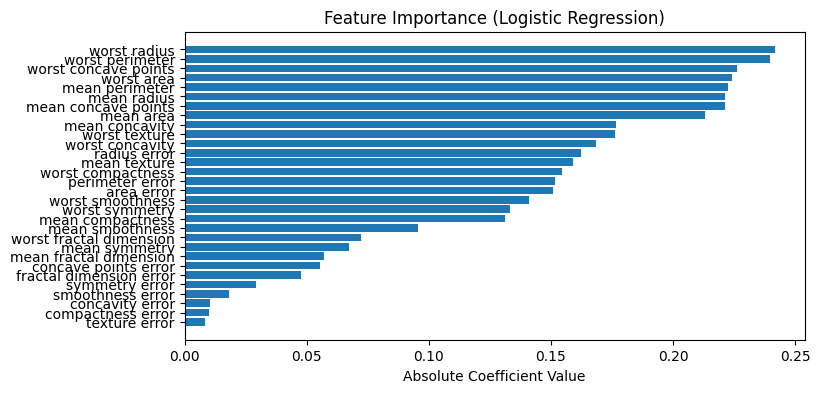

In [ ]:
plt.figure(figsize=(8, 4))
plt.barh(feature_importance["feature"], feature_importance["abs_coefficient"])
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importance (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()

The plot shows the relative importance of each feature based on the magnitude of its coefficient. Features with larger absolute coefficients have a greater impact on the model’s decision boundary.

Positive coefficients increase the probability of the positive class (Malignant), while negative coefficients decrease it, shifting predictions toward Benign.


### Odds Ratios for Top Features

Because the positive class corresponds to **Malignant** tumors, the interpretation of the Odds Ratio is straightforward:

* **Odds Ratio > 1:** Associated with **higher cancer risk**. (e.g., An OR of 2.5 means a 1-unit increase in the feature makes Malignancy 2.5x more likely).
* **Odds Ratio < 1:** Associated with **lower cancer risk** (Protective Factor).

**Mathematical Note:**
In logistic regression, each coefficient represents the change in log-odds of the positive class for a one-unit increase in the corresponding feature. Exponentiating a coefficient converts it into an odds ratio ($OR = e^w$).

Because input features were standardized, a "one-unit increase" corresponds to a **one standard deviation increase** in the original feature value (e.g., increasing tumor size by 1 std dev).

In [ ]:
# Compute odds ratios
feature_importance["odds_ratio"] = np.exp(feature_importance["coefficient"])

# Add direction of effect (Specific to Cancer Risk)
feature_importance["effect"] = np.where(
    feature_importance["odds_ratio"] > 1,
    "Increases Cancer Risk",  # OR > 1
    "Protective (Benign)"     # OR < 1
)


# Create a temporary column for sorting absolute magnitude
feature_importance["abs_importance"] = feature_importance["coefficient"].abs()

# Sort descending (Biggest bars first)
feature_importance = feature_importance.sort_values(by="abs_importance", ascending=False)

# Display top features
top_k = 5
feature_importance[["feature", "coefficient", "odds_ratio", "effect"]].head(top_k)

,feature,coefficient,odds_ratio,effect
20,worst radius,0.241795,1.273533,Increases Cancer Risk
22,worst perimeter,0.239675,1.270836,Increases Cancer Risk
27,worst concave points,0.226235,1.253870,Increases Cancer Risk
23,worst area,0.224033,1.251112,Increases Cancer Risk
2,mean perimeter,0.222424,1.249100,Increases Cancer Risk


The odds ratios provide an interpretable summary of how individual features influence the model’s predictions. Because all features were standardized prior to training, each odds ratio reflects the effect of a one–standard-deviation increase in the corresponding feature.

For the most influential features, the odds ratios are greater than 1, indicating that increases in these features are associated with higher odds of the positive class (malignant tumors).

For example, an odds ratio of approximately 1.27 for worst radius means that a one–standard-deviation increase in this feature multiplies the odds of malignancy by 1.27, corresponding to a 27% increase in the odds of malignancy. The resulting change in predicted probability depends on the baseline malignancy rate. For instance, if baseline odds were 1:1 (50% probability), this feature would shift them to 1.27:1 (≈56% probability).


Overall, these results identify the features that most strongly influence the model’s decision boundary and provide a clear, interpretable link between the learned parameters and clinically meaningful tumor characteristics.


### 5.8 Clinical Decision Thresholds

Throughout our evaluation, we used a probability threshold of 0.5 to convert
predicted probabilities into binary classifications. While this is the default
choice, it implicitly assumes that false positives and false negatives are
equally costly—an assumption that rarely holds in medical diagnostics.

**Cost Asymmetry in Cancer Detection:**
- **False Negative** (missed cancer): Patient does not receive treatment;
  potentially fatal outcome
- **False Positive** (unnecessary biopsy): Patient anxiety, additional testing
  costs, but typically reversible

In production deployment, the threshold should be tuned based on:
1. **Clinical guidelines**: Oncology standards for acceptable miss rates
2. **Downstream costs**: Cost and invasiveness of confirmatory procedures
3. **Patient risk profiles**: Higher sensitivity for high-risk populations
4. **Regulatory requirements**: FDA guidance on diagnostic performance

A lower threshold (e.g., 0.3) would increase sensitivity (fewer missed cancers)
at the cost of more false alarms. The optimal threshold is a business decision
that balances clinical outcomes, resource constraints, and patient welfare—
precisely the type of decision a Chief Analytics Officer must navigate when
deploying AI in regulated environments.

## 6. Conclusion

In this notebook, we implemented logistic regression from scratch using PyTorch to solve a critical medical diagnostic task: detecting malignant tumors.

**Key Takeaways:**
* **Medical Alignment:** We successfully defined the problem such that **Recall (Sensitivity)** measures our ability to detect cancer. The model achieved strong performance, minimizing dangerous "False Negative" errors (missed diagnoses).
* **Algorithm from Scratch:** We built the full pipeline—feature scaling, gradient descent optimization, and binary cross-entropy loss—demonstrating how PyTorch handles automatic differentiation (`autograd`) without high-level wrappers.
* **Interpretability:** By analyzing the learned weights, we identified specific cell features (like larger `worst_radius`) that positively correlate with malignancy. This transparency is a key advantage of logistic regression in healthcare.

**Limitations & Next Steps:**

While the model performs well, Logistic Regression is limited to linear decision boundaries. It assumes that the relationship between tumor features and cancer risk is simple and additive. In the next notebook, we will explore **Multi-Layer Perceptrons (MLPs)**, which can capture complex, non-linear interactions between features to potentially improve sensitivity even further.

**Broader Implications for AI in Healthcare:**

This notebook demonstrates a fundamental principle in deploying AI for regulated industries: **interpretability often matters more than marginal performance gains**. While deep learning models might achieve 1-2% higher accuracy, logistic regression's transparent coefficients allow clinicians to understand *why* the model flagged a case, building trust and enabling regulatory approval. As healthcare AI matures,